In [236]:
import numpy as np
import matplotlib.pyplot as plt


In [237]:
import random
from sklearn.neighbors import NearestNeighbors
import numpy as np
class Smote:
    """
    a class used to implement SMOTE for generating samples
    """
    def __init__(self,samples,N=10,k=5):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0

    def over_sampling(self):
        N=int(self.N)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)  
        for i in range(len(self.samples)):
            #Finds the K-neighbors of a point.
            nnarray=neighbors.kneighbors(self.samples[i].reshape((1,-1)),return_distance=False)[0]  
            self._populate(N,i,nnarray)
        return self.synthetic


    # for each minority class sample i ,choose N of the k nearest neighbors and generate N synthetic samples.
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1
#             print(self.synthetic)


In [238]:

def save_balanced_data( train_i,train_t,test_i,test_t,train_name="balanced_train",test_name="test"):
    
    fp = open('./Balanced-data/'+train_name+'.txt','w+')
    for i in range(len(train_i)):
        d_str = str(train_t[i]) + '\t' +str(train_i[i,:].tolist())[1:-1].replace(',','') +'\n'
        fp.write(d_str)
    fp.close()
    
    fp = open('./Balanced-data/'+test_name+'.txt', 'w+')
    for i in range(len(test_i)):
        d_str = str(test_t[i]) + '\t' + str(test_i[i, :].tolist())[1:-1].replace(',','') + '\n'
        fp.write(d_str)
    fp.close()

    pass


def balance_data(aep_i,aep_t, non_aep_i,non_aep_t,pattern_N= 450,method ='undersampling', test_aep_ratio= 0.3,test_nonaep_ratio= 0.3):
    """

    :param aep_i:
    :param aep_t:
    :param non_aep_i:
    :param non_aep_t:
    :param pattern_N: the number of training input of each pattern
    :param method:
    :param test_aep_ratio:
    :param test_nonaep_ratio:
    :return:
    """

    print("Original data size:")
    print("aep:",len(aep_i),'non_aep:',len(non_aep_i))
    # split test set and train set
    test_aep_sample = int(test_aep_ratio*len(aep_i))
    aep_test_i = aep_i[0:test_aep_sample,:]
    aep_test_t = aep_t[0:test_aep_sample]
    
    test_nonaep_sample = int(test_nonaep_ratio*len(non_aep_i))
    non_aep_test_i = non_aep_i[0:test_nonaep_sample,:]
    non_aep_test_t = non_aep_t[0:test_nonaep_sample]

    # test set
    test_i = np.concatenate((aep_test_i,non_aep_test_i),axis=0)
    test_t = []
    test_t.extend(aep_test_t)
    test_t.extend( non_aep_test_t)

    # train set
    aep_i =aep_i[test_aep_sample:,:]
    aep_t = np.array(aep_t[test_aep_sample:])
    non_aep_i = non_aep_i[test_nonaep_sample:, :]
    non_aep_t = non_aep_t[test_nonaep_sample:]

 
    # balance training set here
    if method == 'oversampling':
        print("Using oversampling...")
        sample_range = len(aep_i)
        indices = np.random.randint(sample_range, size=len(non_aep_i))
        new_aep_i = aep_i[indices,:]
        new_aep_t = aep_t[indices]
        
        train_i = np.concatenate((new_aep_i, non_aep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(non_aep_t)


    elif method == 'undersampling':
        print("Using undersampling...")
        sample_range = len(non_aep_i)
        indices = np.random.randint(sample_range, size=len(aep_i))
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        
        train_i = np.concatenate((aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(aep_t)
        train_t.extend(new_nonaep_t)
        pass
    elif method == 'SMOTE':
        print("Using SMOTE...")
        #generate new aep data
        s= Smote(aep_i,N=10*len(aep_i))
        new_aep_i = s.over_sampling()
        indices = np.random.randint(len(new_aep_i), size=pattern_N)
        new_aep_i = new_aep_i[indices,:]
        new_aep_t = [1.0]*len(new_aep_i)
        
        #downsample non aep data and make aep and non_aep data have same size 
        indices = np.random.randint(len(non_aep_i), size=len(new_aep_i))
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        #first half of data is aep, second half of data is non_aep
        train_i = np.concatenate((new_aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(new_nonaep_t)
        
    else:
        print("Using undersampling+ oversampling...")
        #Default downsample non_aep data and oversample aep data randomly
        #downsample non_aep data
        sample_size = pattern_N
        indices = np.random.randint(len(non_aep_i), size=sample_size)
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        #oversample aep data
        indices = np.random.randint(len(aep_i), size=sample_size)
        new_aep_i = aep_i[indices,:]
        new_aep_t = aep_t[indices]
        
        train_i = np.concatenate((new_aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(new_nonaep_t)
        pass


    return train_i,train_t,test_i,test_t



def load_balanced_data(train_name="balanced_train",test_name="test"):
   
    train_i = []
    train_t = []
    test_i = []
    test_t = []
    fp = open('./Balanced-data/'+train_name+'.txt','r')
    lines= fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        target, inputs =line.split('\t')[0],line.split('\t')[1]
        data = [float(s) for s in inputs.split(' ') if s != '']
        train_t.append(float(target))
        train_i.append(data)
    fp.close()
    
    fp = open('./Balanced-data/'+test_name+'.txt','r')
    lines= fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        target, inputs =line.split('\t')[0],line.split('\t')[1]
        data = [float(s) for s in inputs.split(' ') if s != '']
        test_t.append(float(target))
        test_i.append(data)
    fp.close()
    
    train_i, train_t, test_i, test_t = np.array(train_i),np.array(train_t),np.array(test_i),np.array(test_t)
    
    return train_i, train_t, test_i, test_t



def create_balanced_data(method="SMOTE"):
    fp = open('db4_Diff1f_100_128w_AEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    aep_i = []
    aep_t = []
    non_aep_i = []
    non_aep_t = []

    for line in lines:
        line = line.split('\n')[0]
        data = [float(s) for s in line.split(' ') if s != '']
        aep_i.append(data)
        aep_t.append(1)
    fp.close()

    aep_i = np.array(aep_i)
    aep_t = np.array(aep_t)

    fp = open('db4_Diff1f_100_128w_nonAEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        data = [float(s) for s in line.split(' ') if s != '']
        non_aep_i.append(data)
        non_aep_t.append(0)
    fp.close()
    non_aep_i = np.array(non_aep_i)
    non_aep_t = np.array(non_aep_t)

    
    
    train_i, train_t, test_i, test_t= balance_data(aep_i,aep_t,non_aep_i,non_aep_t,method=method)
    
    train_i, train_t, test_i, test_t = np.array(train_i),np.array(train_t),np.array(test_i),np.array(test_t)
    return train_i, train_t, test_i, test_t


In [239]:
class MLFF():
    def __init__(self,input_shape = 27, bias=False):
#         np.random.seed(1)
        self.weights = {}
        self.bias_enabled = bias
        self.weight_correction = {}
        self.delta ={}
        self.input_shape = input_shape
        self.num_layer = 1 # initialize input layer
        self.func_pair = {'logistic':(self.logistic,self.d_logistic),'relu':(self.relu,self.d_relu),'tanh':(self.tanh,self.d_tanh)}
        self.activate = {}
        self.derivative = {}
        
    def add_layer(self,shape, activation=None,initializer='random'):
        
        if initializer =='zero':
            # zero initializer
            self.weights[self.num_layer] = np.vstack((np.zeros(shape[1]), np.zeros((shape))))
        else:
            #random initializer
            # The first row is bias 
            self.weights[self.num_layer] = np.vstack((10*np.random.random(shape[1])-5, 10*np.random.random(shape)-5))
        self.weight_correction[self.num_layer]= np.zeros((shape[0]+1, shape[1]))
        
        self.num_layer += 1
        
        # the address to activation function
        if activation is not None and activation is not '':
            self.activate[self.num_layer] = self.func_pair[activation][0]
            self.derivative[self.num_layer] = self.func_pair[activation][1]
        else:
            self.activate[self.num_layer] = self.logistic
            self.derivative[self.num_layer] = self.d_logistic
            
        
    def logistic(self, net):
        """
        calculate logistic activation 
        net: weighted input vector 
        """
        k = 0.01
        return 1/(1+ np.exp(-k*net))
    
    def d_logistic(self,net,out):
        """
        calculate derivative of logistic activation
        net: weighted input vector to a logistic layer
        o: output vector from a logisitc layer
        """
        k = 0.01
        return k*out*(1.0- out)

    
    def tanh(self,net):
        """
        calculate tanh activation 
        net: weighted input vector 
        """
        return np.tanh(net)
    
    def d_tanh(self,net,o):
        """
        calculate derivative of tanh activation
        net: input vector to a layer
        o: output vector from a tanh layer
        """
        
        return 1.0-np.square(o)
    
    def relu(self,net):
        """
        calculate leaky relu activation 
        net: weighted input vector 
        """
        k =1.0
        k1= 0.1
        ma = k*np.maximum(net, np.zeros(np.shape(net)))
        mi = k1*np.minimum(net, np.zeros(np.shape(net)))
        return ma+mi
    
    def d_relu(self, net,o):
        """
        calculate derivative of leaky relu activation
        net: weighted input vector to a leaky relu layer
        o: output vector from a leaky relu layer
        """
        
        k = 1.0
        k1 = 0.1
        z = np.zeros(np.shape(net))
        m = np.maximum(z,net)
        deriv = np.where(m>0.0,k,m)
        deriv = np.where(deriv==0.0,k1,deriv)
        return deriv
    
    
    def feedforward(self,inputs,bias= False):
        """
        input: 1-D array input vector
        bias: flag indicating whether using bias or not
        """
        out = {}
        out[1] = inputs
        for i in range(self.num_layer-1):
            layer = i+1
            net = np.dot(out[layer], self.weights[layer][1:,:])
            if bias:
                net += self.weights[layer][0,:]
            out[layer+1]= self.activate[layer+1](net)
            
        return out, out[self.num_layer]
    
        
    def backforward(self,out, target,alpha,momentum_coeff, bias = False,momentum_enabled=False):
       """
        Apply General delta rule (GDR) to update weight correction and dE/do of each layer
        
        out: the dictionary storing all outputs in different layers
        
        target: a scalar target value 
        
        alpha: learning rate used to update weight correction
        
        momentum_coeff: coefficient value used in momentum
        
        bias: a flag indicating whether using bias or not
        
        momentum_enabled: flag indicating whether using momentum
        """
        pred = out[self.num_layer]
        dE_o = -(target- pred)
        prev_net = np.dot(out[self.num_layer-1], self.weights[self.num_layer-1][1:,:])
        if bias:
            prev_net += self.weights[self.num_layer-1][0,:]
        
        
        
        self.delta[self.num_layer] = -np.multiply(dE_o, self.derivative[self.num_layer](prev_net,pred) )
        # calculate delta of each layer
        # calculate delta from layer-2 to the last second layer,since the input layer doesn't have delta
        # delta  of the output layer is determined by output
        for layer in reversed(range(2, self.num_layer)):
            last_delta = self.delta[layer+1] 
            
            dE_o =np.dot(self.weights[layer][1:,:], last_delta)
            prev_net = np.dot(out[layer-1], self.weights[layer-1][1:,:])
            if bias:
                prev_net += self.weights[layer-1][0,:]
                
            d_f =self.derivative[layer](prev_net,out[layer])
            self.delta[layer] = -np.multiply(dE_o, d_f)
            
        #calculate and update weight correction
        for layer in range(1, self.num_layer):
            delta_p = np.multiply(self.delta[layer+1],np.reshape(out[layer], (len(out[layer]), 1)))
            if momentum_enabled:
                self.weight_correction[layer][1:,:] *= momentum_coeff
                
            self.weight_correction[layer][1:,:] += alpha*delta_p 
            #update bias if enabled
            if bias:
                if momentum_enabled:
                    self.weight_correction[layer][0,:] *= momentum_coeff
                self.weight_correction[layer][0,:] += alpha*self.delta[layer+1] 
                
        return None
    
    def reset(self):
        """
        This function is to reset the weight correction matrices and weight matrices to zero matrices
        """
        for layer in range(1, self.num_layer):
            self.weights[layer] = np.zeros(self.weight_correction[layer].shape)
            #reset weight correction after updating weights
            self.weight_correction[layer]= np.zeros(np.shape(self.weight_correction[layer]))
            

    def predict(self, inputs,bias=False):
        """
        This function output a list of 1 or 0 values to indicate if input is AEP or non AEP
        """
        _, preds = self.feedforward(inputs,bias)
        preds = np.array([1 if p>=0.5 else 0 for p in preds])
        return preds
        
    def gradient_descent(self):
        """
        This is a function used to update weights after training one epoch
        Note:
            weight correction is calculated in backforward function
        """
        for layer in range(1, self.num_layer):
            self.weights[layer] += self.weight_correction[layer]
            #reset weight correction after updating weights
            self.weight_correction[layer]= np.zeros(np.shape(self.weight_correction[layer]))

        return None
    
    def train(self,inputs,targets,adaptive_rate=True,alpha0=0.9, beta0=0.99,
              bias =False,momentum_enabled = False,max_iteration = 1000,interval =100,e_th=39):
        """
        Train the network by epoch using feedforward and backforward propagation
        
        inputs: input vectors H used to feed the network. In this case, it is in shape of 900x27
        
        targets: 1-D array target vector with shape (27,)
        
        adaptive_rate: flag used to set whether using a decreasing learning rate as the number of epochs increase
        
        alpah0: learning rate
        
        beta0: momentum coefficient
        
        bias: flag indicating whether using bias or not
        
        momentum_enabled: flag indicating whether using momentum or not
        
        max_iteration: maximum iteration
        
        interval:  the interval of printing log data: Etss, sensitivity and specificity
        
        e_th: threshold of Etss. When Etss is smaller than e_th, training stops
        """
        
        pre_err= 0.0
        sens = 0.0
        spec =0.0

        Etss = []
        sensitivity = []
        specificity = []
        
        alpha = alpha0
        
        for epoch in range(max_iteration):
            err = 0.0
            #need to decrease learning rate alpha, otherwise, it would not decrease error, error doesn't converge
            if adaptive_rate:
                    alpha = alpha0/(0.001*epoch+1.0)
                
            
            beta = beta0

            for i in range(len(inputs)):
                outs, pred= self.feedforward(inputs[i,:],bias)
                
                err  += 0.5*pow(targets[i]-pred[0], 2)
                self.backforward(outs,targets[i],alpha=alpha,
                                 momentum_coeff=beta,
                                 bias=bias,
                                 momentum_enabled =momentum_enabled)
        
            
            #trained by epoch
            m = self.gradient_descent()

            #save data every 100 epochs
            if epoch % 100 == 0:
                preds = self.predict(inputs,bias)
                eap_cnts = float(np.sum(targets))
                TP = np.sum(preds[np.where(targets == 1)])
                sens = TP/eap_cnts
                
                noneap_cnts =float(len(targets) - float(np.sum(targets))) 
                TN = len(preds[np.where(targets == 0)])- np.sum(preds[np.where(targets == 0)])
                spec = TN/noneap_cnts
                sensitivity.append(sens)
                
                specificity.append(spec)
                Etss.append(err)
                #print data after every interval epochs pass
                if  epoch%interval == 0:  
                    print("Epoch:", epoch,"Error:",err,"Sensitivity:",sens,"specificity:",spec)
            
            
            if epoch>1 and ( err<=e_th ):
                break
                pass
            
            else:
                pre_err = err
            
        return Etss, specificity, sensitivity
            

In [240]:
## generate and save balanced data here
# #This block should run once only for generating balanced data
# #Using downsampling simply
# train_i, train_t, test_i, test_t = create_balanced_data(method="undersampling")
# save_balanced_data(train_i, train_t, test_i, test_t,train_name="under_sampling_train",test_name="under_sampling_test")
# print("shape:",np.shape(train_i),np.shape(train_t),np.shape(test_i))

# #Using SMOTE
# train_i, train_t, test_i, test_t = create_balanced_data(method="SMOTE")
# save_balanced_data(train_i, train_t, test_i, test_t,train_name="SMOTE_train_v1",test_name="SMOTE_test_v1")

In [241]:
# # load balanced data and shuffle them
# #This block should run once 
# train_i, train_t, test_i, test_t = load_balanced_data(train_name="SMOTE_train_v1",test_name="SMOTE_test_v1")
# print("shape:",np.shape(train_i),np.shape(train_t),np.shape(test_i),np.shape(test_t))
# from sklearn.utils import shuffle
# train_i, train_t = shuffle(train_i, train_t)

In [242]:
# #normalize data
# #This block should run once only for generating normalized data
# len_train = len(train_i)
# len_test = len(test_i)
# data = np.concatenate([train_i,test_i])
# #normalize data to range [-1,1]
# new_max =1.0
# new_min = -1.0
# norm_data = data
# norm_data = ((data- np.min(data,axis=0))/(np.max(data,axis=0) - np.min(data,axis=0)))*(new_max-new_min)+new_min
# norm_train_i = norm_data[0:len_train,:]
# test_i = norm_data[len_train:,:]
# save_balanced_data(norm_train_i,train_t,test_i,test_t,train_name="normalized_train",test_name="normalized_test")

In [243]:
norm_train_i,train_t,test_i,test_t= load_balanced_data(train_name="normalized_train",test_name="normalized_test")
np.shape(norm_data), np.shape(data), np.shape(norm_train_i), np.shape(test_i)

((1668, 27), (1668, 27), (900, 27), (768, 27))

In [244]:
# save weights
def save_weights(w,model):
    import json
    fp = open("weights/model_case_"+str(model)+".txt","w+")
    fp.write(json.dumps(w))
    fp.close()

def load_weights(model,layer=3):
    import json
    fp = open("weights/model_case_"+str(model)+".txt","r")
    line= fp.read()
    w= json.loads(line)
    d={}
    for i in range(layer):
        l= i+1
        d[l]=np.array(w[str(l)])
    
    return d

def save_curves(case,name,epoch,err, specif,sens):
    import json
    fp = open("Case-"+str(case)+"-data"+"/log_"+name+".txt","w+")
    for i in range(len(epoch)):
        fp.write(str(epoch[i])+" "+str(err[i])+" "+str(sens[i])+" "+str(specif[i])+"\n")
           
    fp.close()

In [245]:
#initialize weights of case 1 randomly
d = 27
model_1 = MLFF(input_shape  = d)
model_1.add_layer((d,d),activation='relu')
model_1.add_layer((d,2*d+1),activation='relu')
model_1.add_layer((2*d+1,1),activation='')


# # initialize and save weights
# d1= {}
# for k in model_1.weights.keys():
#     model_1.weights[k][0,:] = np.zeros(np.shape(model_1.weights[k][0,:] ))
#     d2[k]=model_1.weights[k].tolist()
# save_weights( d1,"1")

In [246]:
#case 1: determine learning rate
model_1.reset()
model_1.weights=load_weights("1",layer=len(model_1.weights.keys()))
Etss_1c, specif_1c, sens_1c = model_1.train(norm_train_i,train_t,adaptive_rate = True,alpha0= 0.017,
                                   bias=False,momentum_enabled=False ,max_iteration = 5000)



Epoch: 0 Error: 216.36152665838569 Sensitivity: 0.8822222222222222 specificity: 0.14666666666666667
Epoch: 100 Error: 219.0110314294777 Sensitivity: 1.0 specificity: 0.024444444444444446
Epoch: 200 Error: 130.75164891883819 Sensitivity: 0.2 specificity: 0.9488888888888889
Epoch: 300 Error: 139.9885537567202 Sensitivity: 0.24222222222222223 specificity: 0.9133333333333333
Epoch: 400 Error: 119.58981349514515 Sensitivity: 0.21333333333333335 specificity: 0.9111111111111111
Epoch: 500 Error: 98.30877228011472 Sensitivity: 0.9866666666666667 specificity: 0.41555555555555557
Epoch: 600 Error: 95.30871063834402 Sensitivity: 0.9777777777777777 specificity: 0.46
Epoch: 700 Error: 91.46302942994367 Sensitivity: 0.98 specificity: 0.48444444444444446
Epoch: 800 Error: 86.18012829752305 Sensitivity: 0.9688888888888889 specificity: 0.52
Epoch: 900 Error: 78.07028317375465 Sensitivity: 0.9711111111111111 specificity: 0.5555555555555556
Epoch: 1000 Error: 76.75019190387778 Sensitivity: 0.98 specifici

In [247]:
epochs_1c=  [i*100 for i in range(len(Etss_1c))]
save_curves(1,"adaptive_rate_0.017",epochs_1c,Etss_1c, specif_1c, sens_1c )
#save weights
d1= {}
for k in model_1.weights.keys():
    d1[k]=model_1.weights[k].tolist()
save_weights( d1,"1_c")

In [248]:
preds = model_1.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 1 acc:",acc)


Model 1 acc: 0.9140625


In [249]:
#case 1: determine learning rate
model_1.reset()
model_1.weights=load_weights("1",layer=len(model_1.weights.keys()))
Etss_1a, specif_1a, sens_1a = model_1.train(norm_train_i,train_t,adaptive_rate = False,alpha0= 0.001,
                                   bias=False,momentum_enabled=False ,max_iteration = 5000)


Epoch: 0 Error: 216.36152665838569 Sensitivity: 0.9777777777777777 specificity: 0.02666666666666667
Epoch: 100 Error: 135.12506521043755 Sensitivity: 0.5888888888888889 specificity: 0.5711111111111111
Epoch: 200 Error: 120.97630716372754 Sensitivity: 0.5977777777777777 specificity: 0.6466666666666666
Epoch: 300 Error: 108.29191062553117 Sensitivity: 0.6711111111111111 specificity: 0.6422222222222222
Epoch: 400 Error: 97.17411811781368 Sensitivity: 0.7311111111111112 specificity: 0.6355555555555555
Epoch: 500 Error: 93.07797146350585 Sensitivity: 0.7488888888888889 specificity: 0.6733333333333333
Epoch: 600 Error: 92.36986479360075 Sensitivity: 0.72 specificity: 0.6377777777777778
Epoch: 700 Error: 89.87663867510079 Sensitivity: 0.7311111111111112 specificity: 0.6488888888888888
Epoch: 800 Error: 93.79788643932696 Sensitivity: 0.7088888888888889 specificity: 0.6244444444444445
Epoch: 900 Error: 89.68175429450864 Sensitivity: 0.7288888888888889 specificity: 0.6666666666666666
Epoch: 1000

In [250]:

epochs_1a = [i*100 for i in range(len(Etss_1a))]
save_curves(1,"rate_0.001",epochs_1a,Etss_1a, specif_1a, sens_1a )
#save weights
d1= {}
for k in model_1.weights.keys():
    d1[k]=model_1.weights[k].tolist()
    
save_weights( d1,"1_a")

In [251]:

preds = model_1.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 1 acc:",acc)


Model 1 acc: 0.7005208333333334


In [252]:
#case 1: determine learning rate
model_1.reset()
model_1.weights=load_weights("1",layer=len(model_1.weights.keys()))
Etss_1b, specif_1b, sens_1b = model_1.train(norm_train_i,train_t,adaptive_rate = False,alpha0= 0.003,
                                   bias=False,momentum_enabled=False ,max_iteration = 5000,interval=100)
epochs_1b=  [i*100 for i in range(len(Etss_1b))]
save_curves(1,"rate_0.003",epochs_1b,Etss_1b, specif_1b, sens_1b )
#save weights
d1= {}
for k in model_1.weights.keys():
    d1[k]=model_1.weights[k].tolist()
save_weights( d1,"1_b")

Epoch: 0 Error: 216.36152665838569 Sensitivity: 0.9777777777777777 specificity: 0.03111111111111111
Epoch: 100 Error: 122.63364849407031 Sensitivity: 0.3244444444444444 specificity: 0.8444444444444444
Epoch: 200 Error: 121.58359279200369 Sensitivity: 0.31333333333333335 specificity: 0.8644444444444445
Epoch: 300 Error: 112.42643865007042 Sensitivity: 0.35777777777777775 specificity: 0.8666666666666667
Epoch: 400 Error: 96.83070354607081 Sensitivity: 0.48 specificity: 0.82
Epoch: 500 Error: 94.94336748981786 Sensitivity: 0.5688888888888889 specificity: 0.8177777777777778
Epoch: 600 Error: 88.3643196362301 Sensitivity: 0.6022222222222222 specificity: 0.8044444444444444
Epoch: 700 Error: 86.55530276291157 Sensitivity: 0.6088888888888889 specificity: 0.7777777777777778
Epoch: 800 Error: 85.28619683818732 Sensitivity: 0.5955555555555555 specificity: 0.7733333333333333
Epoch: 900 Error: 94.64390970140335 Sensitivity: 0.7577777777777778 specificity: 0.6
Epoch: 1000 Error: 84.65010091854926 Se

In [253]:
preds = model_1.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 1 acc:",acc)
# print(Etss_1b, specif_1b, sens_1b )

Model 1 acc: 0.8059895833333334


In [254]:
#case 3 uses the weights from case 1
model_3 = MLFF(input_shape  = d)
model_3.add_layer((d,d),activation='relu')
model_3.add_layer((d,2*d+1),activation='relu')
model_3.add_layer((2*d+1,1),activation='')

#backup weights of case 1
# model_1_weights = model_1.weights.copy()
d3= {}
for k in model_3.weights.keys():
    d3[k]=model_3.weights[k].tolist()



In [262]:
model_3.reset()
model_3.weights=load_weights("1",layer=len(model_1.weights.keys()))
Etss_3a, specif_3a, sens_3a = model_3.train(norm_train_i,train_t,adaptive_rate = True,alpha0= 0.01,
                                            beta0=0.99,bias=False,momentum_enabled=True ,max_iteration = 5000)

Epoch: 0 Error: 216.36152665838569 Sensitivity: 0.9777777777777777 specificity: 0.028888888888888888
Epoch: 100 Error: 143.31599613066595 Sensitivity: 0.7044444444444444 specificity: 0.41555555555555557
Epoch: 200 Error: 116.3531510174063 Sensitivity: 0.6711111111111111 specificity: 0.5622222222222222
Epoch: 300 Error: 102.77597485655349 Sensitivity: 0.7622222222222222 specificity: 0.6022222222222222
Epoch: 400 Error: 98.05597201928794 Sensitivity: 0.7066666666666667 specificity: 0.6377777777777778
Epoch: 500 Error: 93.01042371963341 Sensitivity: 0.7355555555555555 specificity: 0.6622222222222223
Epoch: 600 Error: 90.65490176802454 Sensitivity: 0.7422222222222222 specificity: 0.6822222222222222
Epoch: 700 Error: 89.07208872609773 Sensitivity: 0.7622222222222222 specificity: 0.6888888888888889
Epoch: 800 Error: 87.7953025580968 Sensitivity: 0.7755555555555556 specificity: 0.68
Epoch: 900 Error: 86.2254058681618 Sensitivity: 0.78 specificity: 0.6955555555555556
Epoch: 1000 Error: 85.1256

In [263]:
epochs_3a = [i*100 for i in range(len(Etss_3a))]
save_curves(3,"momentum",epochs_3a,Etss_3a, specif_3a, sens_3a )
#save weights
d3= {}
for k in model_3.weights.keys():
    d3[k]=model_3.weights[k].tolist()
save_weights( d3,"3_a")

In [264]:
preds = model_3.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 3 acc:",acc)
# print(Etss_1b, specif_1b, sens_1b )

Model 3 acc: 0.7643229166666666


Text(0,0.5,'Etss')

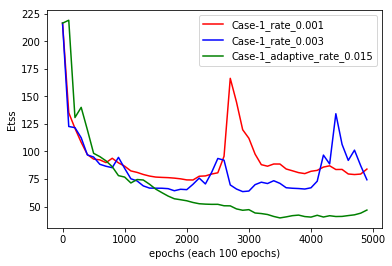

In [265]:

plt.plot(epochs_1a, Etss_1a,'r')
plt.plot(epochs_1b, Etss_1b,'b')
plt.plot(epochs_1c, Etss_1c,'g')
plt.legend(["Case-1_rate_0.001","Case-1_rate_0.003","Case-1_adaptive_rate_0.015"])
plt.xlabel("epochs (each 100 epochs)")
plt.ylabel("Etss")

Text(0,0.5,'Etss')

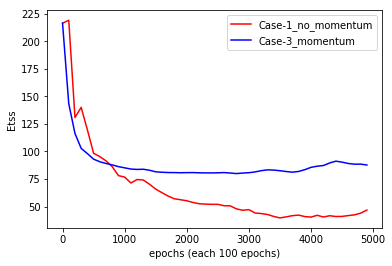

In [266]:
epochs = [i*100 for i in range(len(Etss_3a))]
plt.plot(epochs_1c, Etss_1c,'r')
plt.plot(epochs_3a, Etss_3a,'b')
plt.legend(["Case-1_no_momentum","Case-3_momentum"])
plt.xlabel("epochs (each 100 epochs)")
plt.ylabel("Etss")

Text(0,0.5,'Sensitivity')

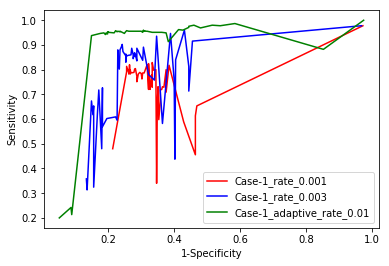

In [267]:
ind= np.argsort(specif_1a)
specif_1a = np.array(specif_1a)[ind]
sens_1a = np.array(sens_1a)[ind]


ind= np.argsort(specif_1b)
specif_1b = np.array(specif_1b)[ind]
sens_1b = np.array(sens_1b)[ind]

ind= np.argsort(specif_1c)
specif_1c = np.array(specif_1c)[ind]
sens_1c = np.array(sens_1c)[ind]

plt.plot(1-np.array(specif_1a), sens_1a,'r')
plt.plot(1-np.array(specif_1b), sens_1b,'b')
plt.plot(1-np.array(specif_1c), sens_1c,'g')
plt.legend(["Case-1_rate_0.001","Case-1_rate_0.003","Case-1_adaptive_rate_0.01"])
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")

Text(0,0.5,'Sensitivity')

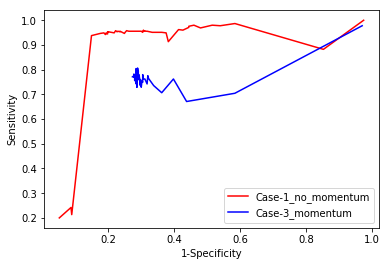

In [268]:

ind= np.argsort(specif_3a)
specif_3a = np.array(specif_3a)[ind]
sens_3a = np.array(sens_3a)[ind]

ind= np.argsort(specif_1c)
specif_1c = np.array(specif_1c)[ind]
sens_1c = np.array(sens_1c)[ind]


plt.plot(1-np.array(specif_1c), sens_1c,'r')
plt.plot(1-np.array(specif_3a), sens_3a,'b')
plt.legend(["Case-1_no_momentum","Case-3_momentum"])
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")